# Use `seaduck.OceInterp` with ECCO

`seaduck` Lagrangian particle demonstration. This version uses a reduced version of the ECCO MITgcm velocity field data.

authors: Wenrui Jiang, Tom Haine Feb '23

In [1]:
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import seaduck as sd

mpl.rcParams["figure.dpi"] = 300

## Loading Dataset

The ECCO MITgcm run is a low-resolution global state estimate. An artifact of note is that this dataset has complex grid topology, which means there is a `face` (also called tile) dimension in the dataset.

A built-in function in `seaduck.utils` can help access the snippet of ECCO that this example is based on.

In [2]:
ecco = sd.utils.get_dataset("ecco")
ecco

<xarray.Dataset>
Dimensions:    (face: 13, Y: 90, X: 90, Z: 50, Yp1: 90, Xp1: 90, Zp1: 51,
                Zl: 50, Zu: 50, time: 3, nv: 2, time_midp: 2)
Coordinates: (12/42)
    CS         (face, Y, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Depth      (face, Y, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    HFacC      (Z, face, Y, X) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    HFacS      (Z, face, Yp1, X) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    HFacW      (Z, face, Y, Xp1) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    PHrefC     (Z) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    ...         ...
    rAw        (face, Y, Xp1) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (face, Yp1, Xp1) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 1992-03-16T12:00:00
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
  * time_midp  (time_midp) datetime64[ns] 1992-01-31T12:00:00 1992-03-01T12:0...
    timestep   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    UVELMASS1  (Z, face, Y, Xp1) float16 dask.array<chunksize=(25, 7, 45, 45), meta=np.ndarray>
    VVELMASS1  (Z, face, Yp1, X) float16 dask.array<chunksize=(25, 7, 45, 45), meta=np.ndarray>
    WVELMASS1  (Zl, face, Y, X) float16 dask.array<chunksize=(25, 7, 45, 45), meta=np.ndarray>
    UVELMASS   (time, Z, face, Y, Xp1) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    WVELMASS   (time, Zl, face, Y, X) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VVELMASS   (time, Z, face, Yp1, X) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SALT       (time, Z, face, Y, X) float64 0.6558 0.9147 ... 0.596 0.9941
    SALT_snap  (time_midp, Z, face, Y, X) float64 0.2282 0.6217 ... 0.4157
    ETAN       (time, face, Y, X) float64 0.6558 0.9147 0.2669 ... 0.5445 0.777
    ETAN_snap  (time_midp, face, Y, X) float64 0.2282 0.6217 ... 0.3792 0.8122
Attributes: (12/16)
    OceanSpy_description:       ECCO v4r4 3D dataset, ocean simulations on LL...
    OceanSpy_face_connections:  {'face': {0: {'X': ((12, 'Y', False), (3, 'X'...
    OceanSpy_grid_coords:       {'Y': {'Y': None, 'Yp1': -0.5}, 'X': {'X': No...
    OceanSpy_name:              ECCO_v4r4
    OceanSpy_parameters:        {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho...
    date_created:               Mon Dec 30 11:13:26 2019
    ...                         ...
    geospatial_vertical_max:    -5.0
    geospatial_vertical_min:    -5906.25
    nx:                         90
    ny:                         90
    nz:                         50
    title:                      ECCOv4 MITgcm grid information

```{admonition} Access full ECCO dataset
The ECCO dataset is publicly available on [SciServer](https://sciserver.org/). The simulation output can be opened using the [OceanSpy](https://github.com/hainegroup/oceanspy) package with the [`from_catalog`](https://oceanspy.readthedocs.io/en/latest/generated/oceanspy.open_oceandataset.from_catalog.html#oceanspy.open_oceandataset.from_catalog) method (Oceanspy is already available in the Oceanography container environment on SciServer).

Choose between the monthly-mean data ('ECCO')

`ecco = ospy.open_oceandataset.from_catalog("ECCO")._ds`

or the daily-mean data ('daily_ecco').

`ecco = ospy.open_oceandataset.from_catalog('daily_ecco')._ds`

Click [here](https://dev-poseidon-ocean.pantheonsite.io/products/datasets/) for a full list of the datasets hosted on SciServer.
```

## Experiment setup

Specify the parameters for the particles (number, positions, start time).

In [3]:
# Define the extend of the box
west = -90.0
east = 0.0
south = 23.0
north = 67.0
shallow = -10.0
deep = -10.0

time = "1992-02-15"

Nlon = 80  # How many along longitudinal direction?
Nlat = 80  # How many along latitudinal direction?
Ndep = 1  # How many along vertical direction?

x, y, z, t = sd.utils.easy_3d_cube(
    (east, west, Nlon),
    (south, north, Nlat),
    (shallow, deep, Ndep),
    time,
    print_total_number=True,
)

A total of 6400 positions are defined.


Plot the particle positions

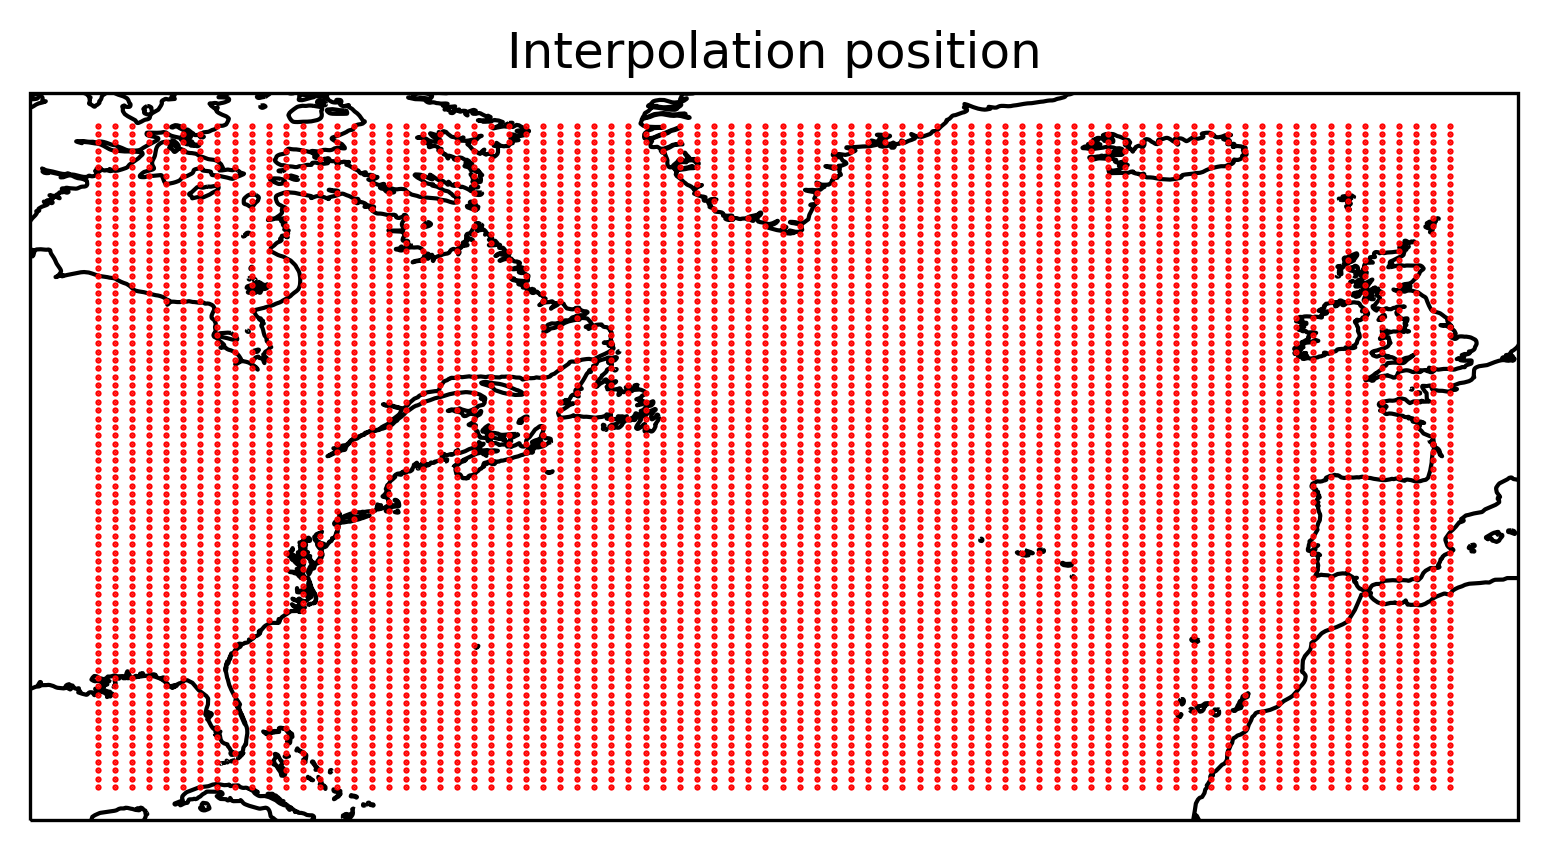

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.plot(x, y, "ro", markersize=0.5)
ax.coastlines()
# ax.set_xlim([-25, 0])
# ax.set_ylim([50, 70])
ax.set_title("Interpolation position")
plt.show()

## Let's explore `seaduck.OceInterp`

This is the most high-level function of the package. Yes, it is very easy to use.

In [5]:
help(sd.OceInterp)

Help on function OceInterp in module seaduck.oceinterp:

OceInterp(od, varList, x, y, z, t, kernelList=None, lagrangian=False, lagrange_kwarg={}, update_stops='default', return_in_between=True, return_pt_time=True, kernel_kwarg={})
    Interp for people who just want to take a quick look.
    
    **This is the centerpiece function of the package, through which
    you can access almost all of its functionality.**.
    
    Parameters
    ----------
    od: OceInterp.OceData object or xarray.Dataset (limited support for netCDF Dataset)
        The dataset to work on.
    varList: str or list
        A list of variable or pair of variables.
    kernelList: OceInterp.KnW or list of OceInterp.KnW objects, optional
        Indicates which kernel to use for each interpolation.
    x, y, z: numpy.ndarray
        The location of the particles, where x and y are in degrees,
        and z is in meters (deeper locations are represented by more negative values).
    t: numpy.ndarray
        In th

### Interpolate these ECCO fields at Eulerian positions.

In [6]:
[s, (u, v), eta, mask] = sd.OceInterp(
    ecco, ["SALT", ("UVELMASS", "VVELMASS"), "ETAN", "maskC"], x, y, z, t
)

/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/utils.py:522: RuntimeWarning: invalid value encountered in divide
  ry[order2] = ((-bb + np.sqrt(det2)) / (2 * aa))[order2]
/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/utils.py:526: RuntimeWarning: divide by zero encountered in divide
  (y - py[0]) / (py[1] - py[0]) + (y - py[3]) / (py[2] - py[3])
/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/utils.py:526: RuntimeWarning: invalid value encountered in add
  (y - py[0]) / (py[1] - py[0]) + (y - py[3]) / (py[2] - py[3])
/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/utils.py:528: RuntimeWarning: divide by zero encountered in divide
  rx[~rot_rectilinear] = ((x - a[0] - a[2] * ry) / (a[1] + a[3] * ry))[
/Users/thai

Plot the interpolated salinity, $u$, $\eta$ field.

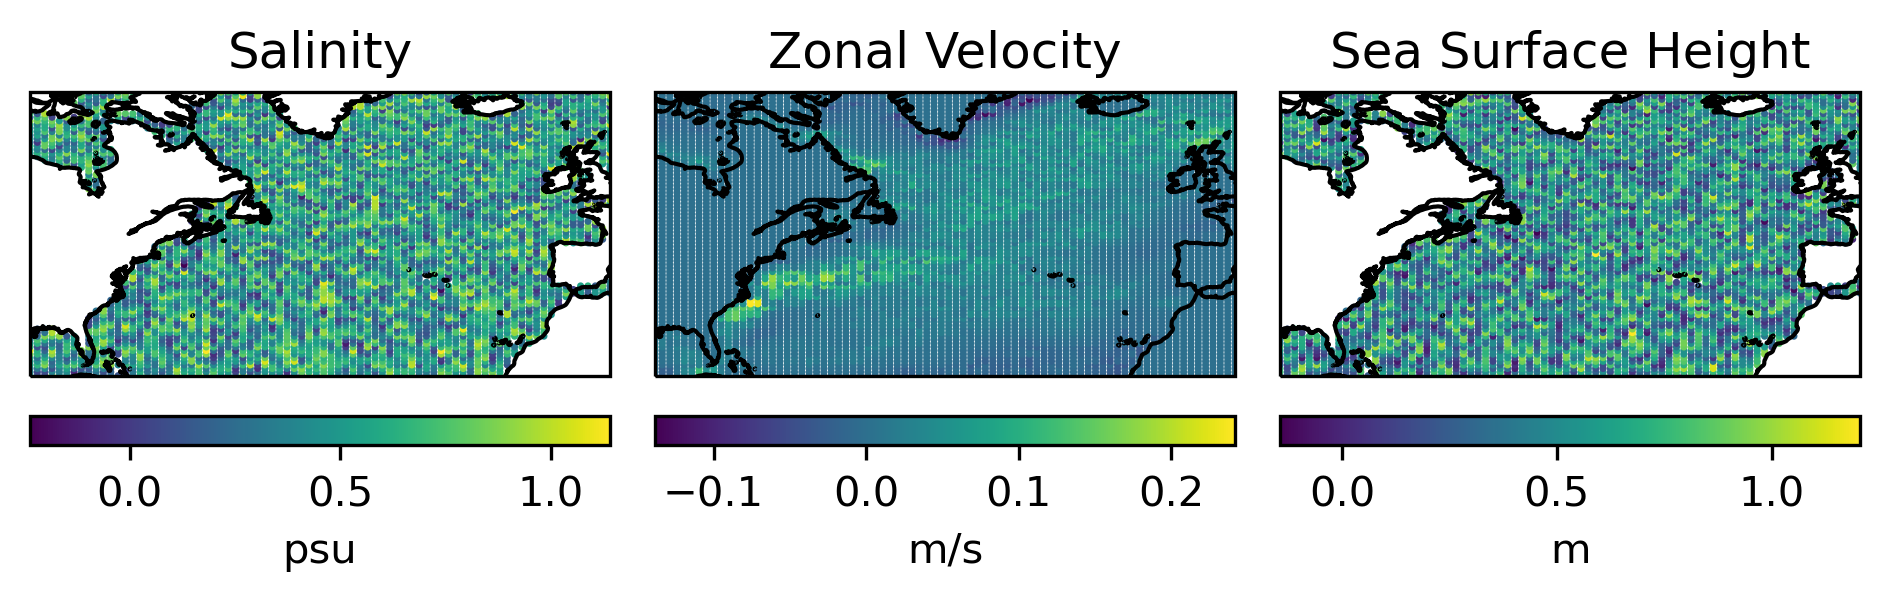

In [7]:
unit = ["psu", "m/s", "m"]
name = ["Salinity", "Zonal Velocity", "Sea Surface Height"]
for i, var in enumerate([s, u, eta]):
    ax = plt.subplot(1, 3, 1 + i, projection=ccrs.PlateCarree())
    c = ax.scatter(x, y, c=var, s=0.5)
    ax.coastlines()
    ax.set_xlim([west, east])
    ax.set_ylim([south, north])
    plt.colorbar(c, location="bottom", label=unit[i], pad=0.03)
    ax.set_title(name[i])
plt.tight_layout()
plt.show()

The salinity and the sea surface height variable here are not model output but randomly generated noise and there are values on land as well. However, the package respects the mask provided by the model, so even though there are apparently values on land, NaNs are returned.

This is not the case for velocity. The mask for the staggered velocity field is not provided by the model, so the actual value (zero here) is returned.

### Now compute Lagrangian trajectories for these particles.

First, define the `start_time` and `end_time`. Here the particles are integrated backwards in time.

In [8]:
start_time = "1992-01-17"
end_time = "1992-03-12"

t_bnds = np.array(
    [
        sd.utils.convert_time(start_time),
        sd.utils.convert_time(end_time),
    ]
)

### Perform the particle trajectory simulation.

To switch between Lagrangian and Eulerian modes, you only need to change the `lagrangian` keyword argument.

The following code block simulates the trajectory and records the salinity along the particle trajectories, as well as their (lat,lon) positions.

In [9]:
stops, [s, raw, lat, lon] = sd.OceInterp(
    ecco,
    ["SALT", "__particle.raw", "__particle.lat", "__particle.lon"],
    x,
    y,
    z,
    t_bnds,
    lagrangian=True,
    return_pt_time=True,
)

/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/lagrangian.py:83: RuntimeWarning: invalid value encountered in divide
  tl = np.log(1 - du / u * (0.5 + x0)) / du
/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/lagrangian.py:83: RuntimeWarning: divide by zero encountered in log
  tl = np.log(1 - du / u * (0.5 + x0)) / du
/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/lagrangian.py:83: RuntimeWarning: invalid value encountered in log
  tl = np.log(1 - du / u * (0.5 + x0)) / du
/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscellaneous/From Wenrui/seaduck/seaduck/lagrangian.py:84: RuntimeWarning: invalid value encountered in divide
  tr = np.log(1 + du / u * (0.5 - x0)) / du
/Users/thaine1/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/Python/Miscel

There are 4 output times. See also the diagnostic output from running the integration.

In [10]:
len(stops)

3

The `raw` output is a list of `seaduck.Position` objects which stores, of course, the position of the particle at specific times.

In [11]:
raw

### Plot the interpolated salinity field on the final particle positions.

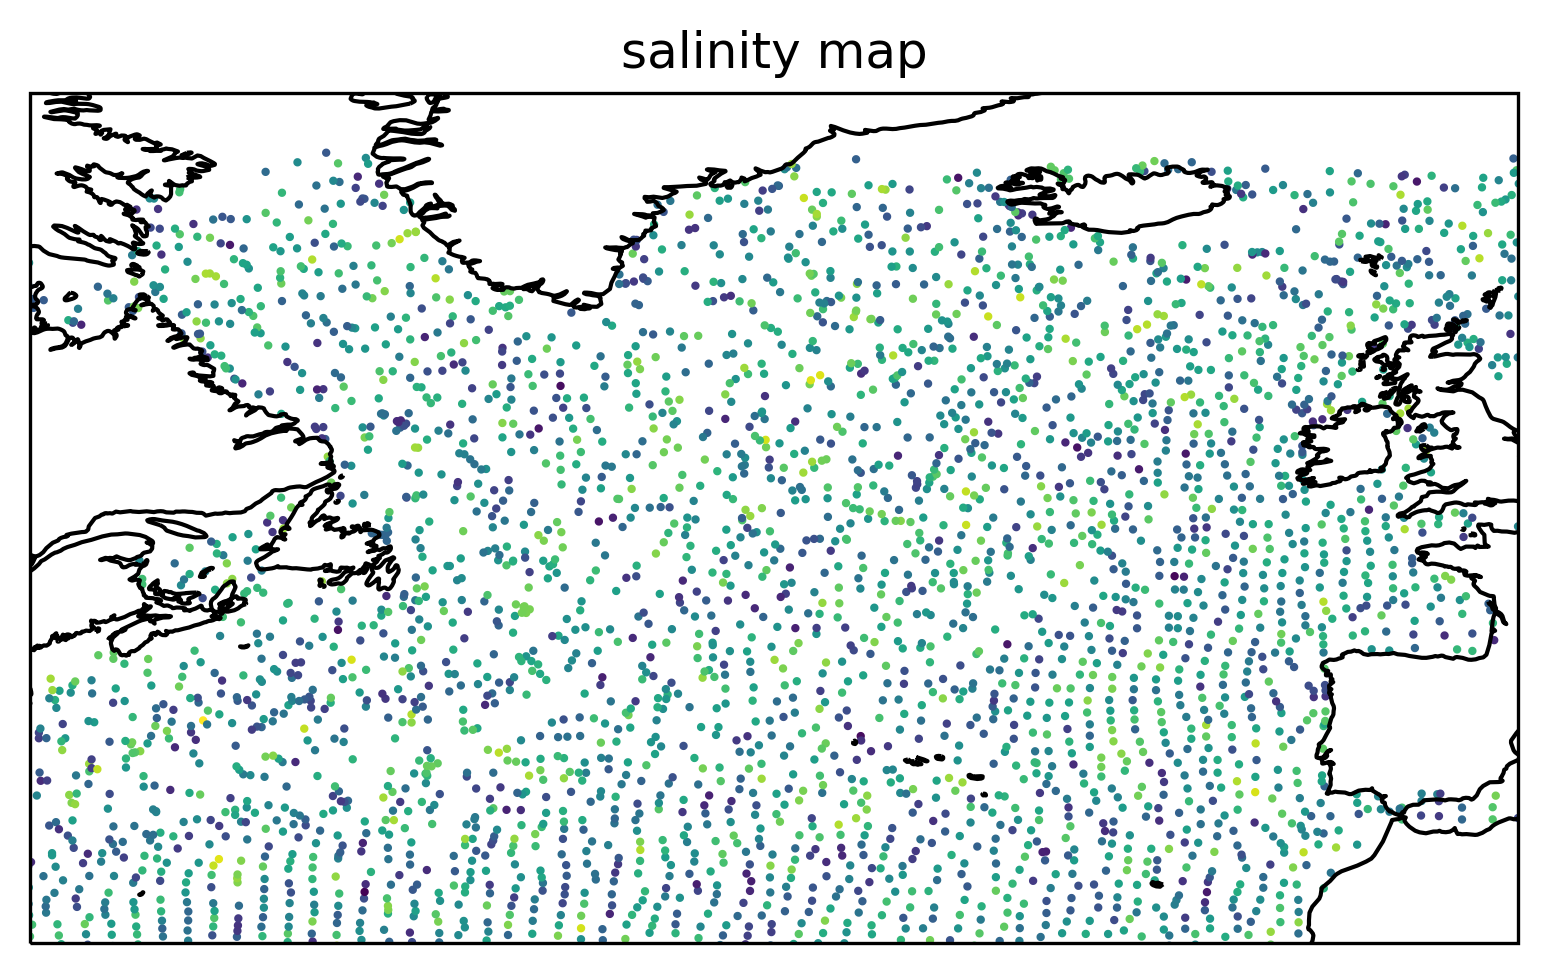

In [12]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(lon[-1], lat[-1], c=s[-1], s=1)
ax.coastlines()
ax.set_xlim([-70, 0])
ax.set_ylim([30, 70])
plt.title("salinity map")
plt.show()

## Calculate derivatives

### Kernel object

The `kernel` object defines which neighboring points are used for the interpolation, and also what kind of operation is conducted. The default is interpolation. However, you can also use this class to calculate derivatives.

In [13]:
KnW = sd.kernel_weight.KnW
help(KnW)

Help on class KnW in module seaduck.kernel_weight:

class KnW(builtins.object)
 |  KnW(kernel=array([[ 0,  0],
 |         [ 0,  1],
 |         [ 0,  2],
 |         [ 0, -1],
 |         [ 0, -2],
 |         [-1,  0],
 |         [-2,  0],
 |         [ 1,  0],
 |         [ 2,  0]]), inheritance='auto', hkernel='interp', vkernel='nearest', tkernel='nearest', h_order=0, ignore_mask=False)
 |  
 |  Kernel object.
 |  
 |  A class that describes anything about the
 |  interpolation/derivative kernel to be used.
 |  
 |  Parameters
 |  ----------
 |  kernel: numpy.ndarray
 |      The largest horizontal kernel to be used
 |  inheritance: list
 |      The inheritance sequence of the kernels
 |  hkernel: str
 |      What to do in the horizontal direction
 |      'interp', 'dx', or 'dy'?
 |  tkernel: str
 |      What kind of operation to do in the temporal dimension:
 |      'linear', 'nearest' interpolation, or 'dt'
 |  vkernel: str
 |      What kind of operation to do in the vertical:
 |      'l

Let's define derivative kernels for $\partial / \partial z$, $\partial^2 / \partial x^2$, and $\partial / \partial t$ as examples:

In [14]:
default = KnW()
dz_kernel = KnW(vkernel="dz")
dx2_kernel = KnW(hkernel="dx", h_order=2, inheritance=None, tkernel="linear")
dt_kernel = KnW(tkernel="dt")

Apply the kernels to the ECCO fields:

In [15]:
[dsdz, (d2udx2, dvdt)] = sd.OceInterp(
    ecco,
    {"SALT": dz_kernel, ("UVELMASS", "VVELMASS"): (dx2_kernel, dt_kernel)},
    x,
    y,
    z,
    t,
)

result will be in the order of ['SALT', ('UVELMASS', 'VVELMASS')]


### Plot one of the differentiated fields on the initial particle positions.

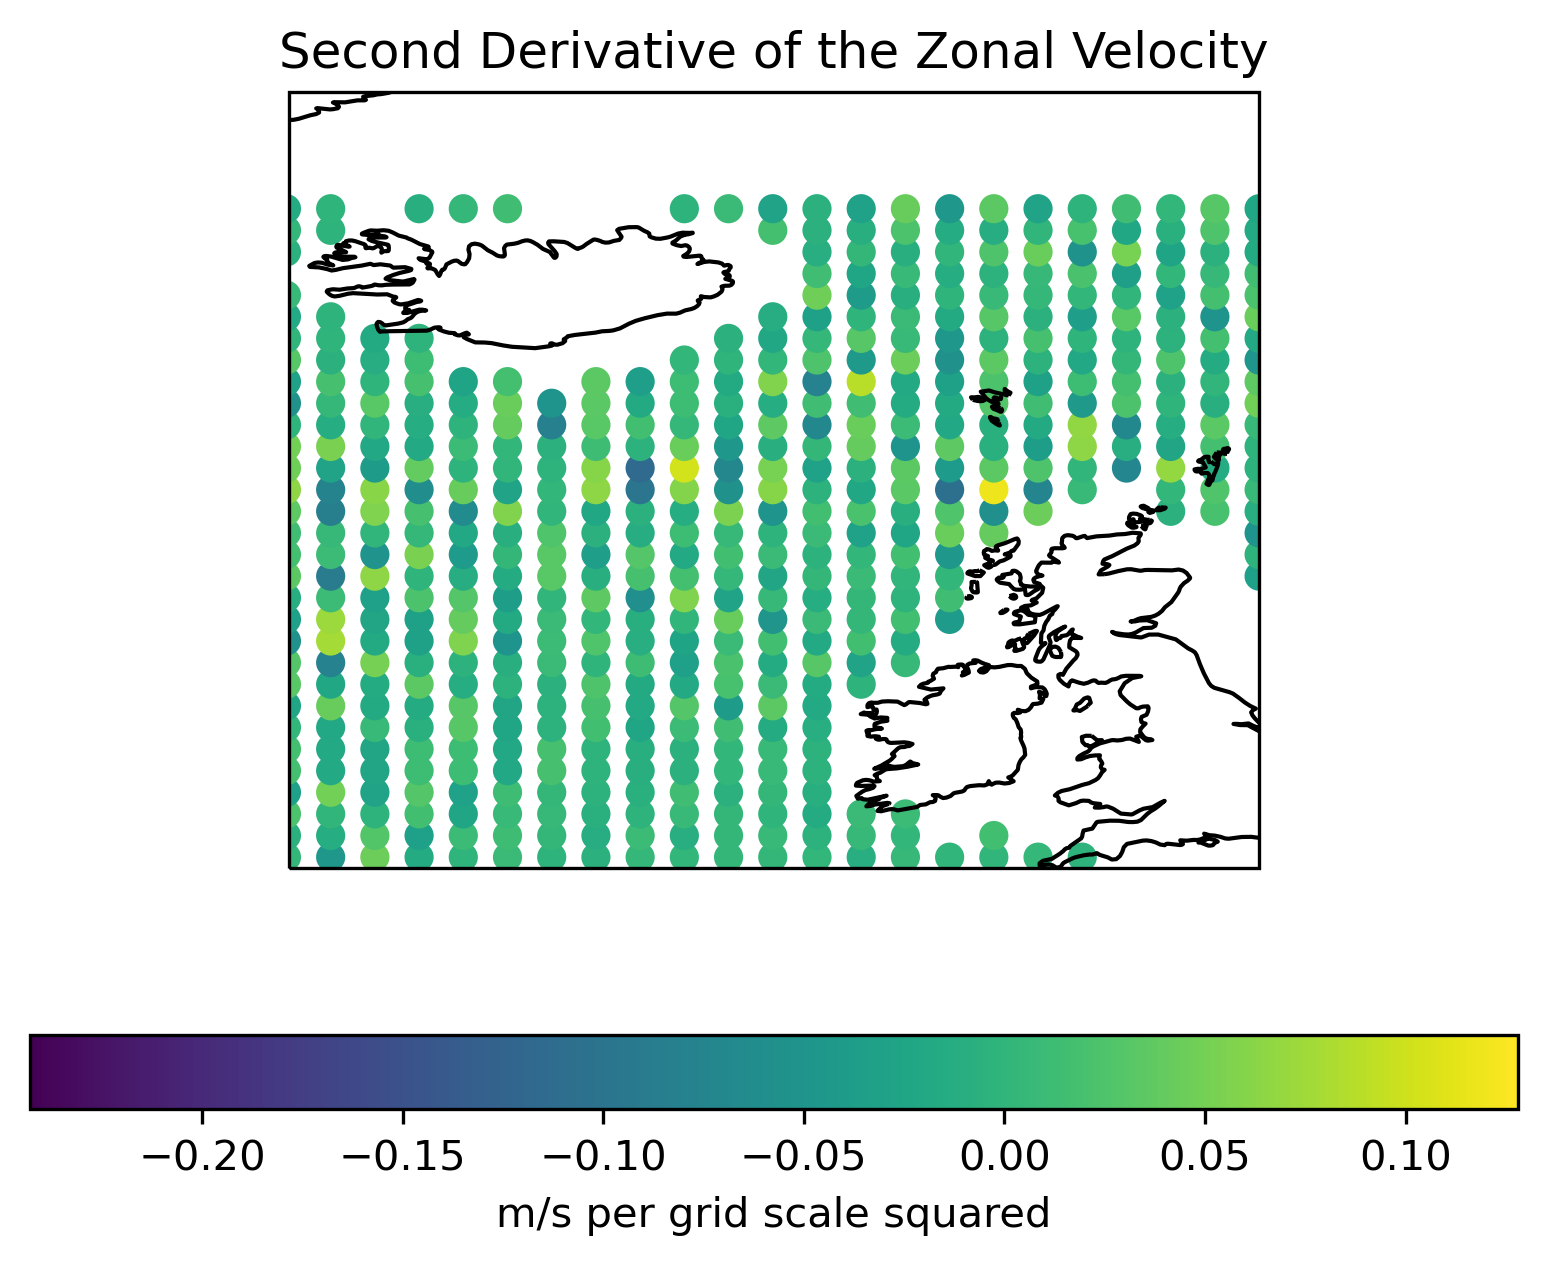

In [16]:
ax = plt.axes(projection=ccrs.PlateCarree())
c = ax.scatter(x, y, c=d2udx2)
ax.coastlines()
ax.set_xlim([-25, 0])
ax.set_ylim([50, 70])
plt.colorbar(c, location="bottom", label="m/s per grid scale squared")
plt.title("Second Derivative of the Zonal Velocity")
plt.show()